Processing Station USW00094846...
Average TAVG for Station USW00094846: 51.64


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


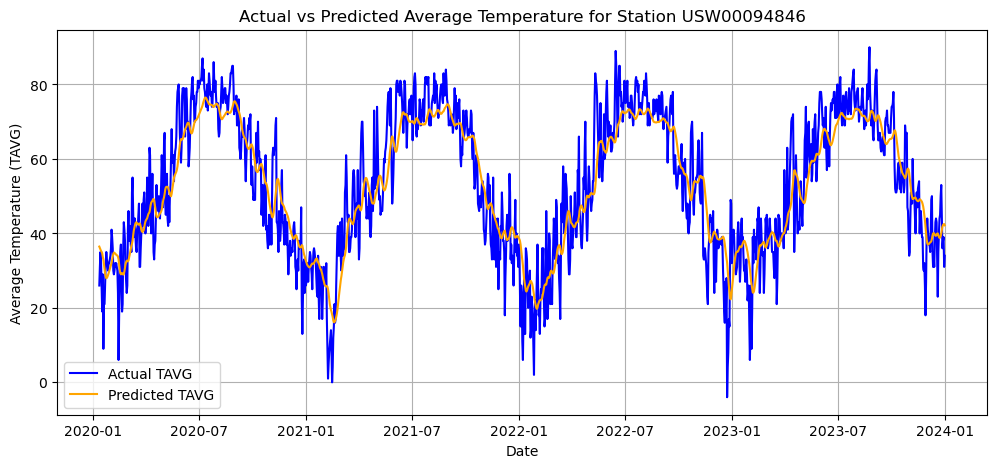

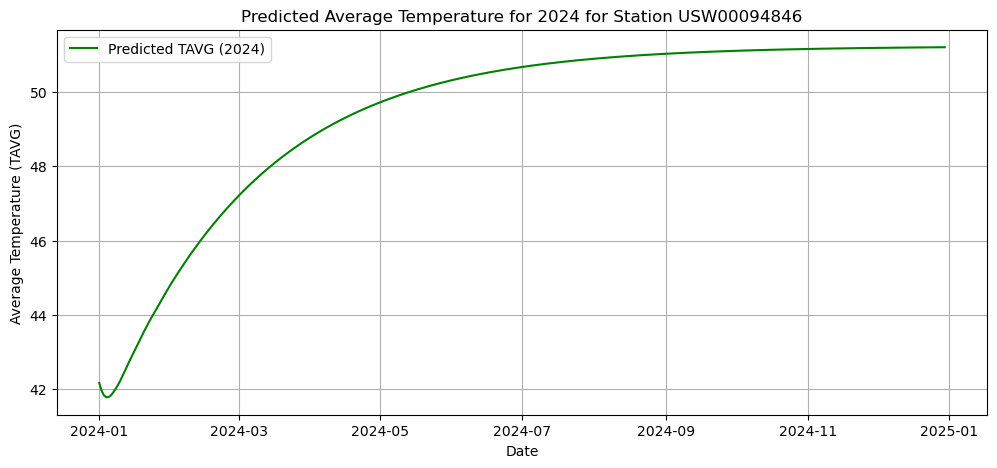

Processing Station USW00026617...
Average TAVG for Station USW00026617: 30.32


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


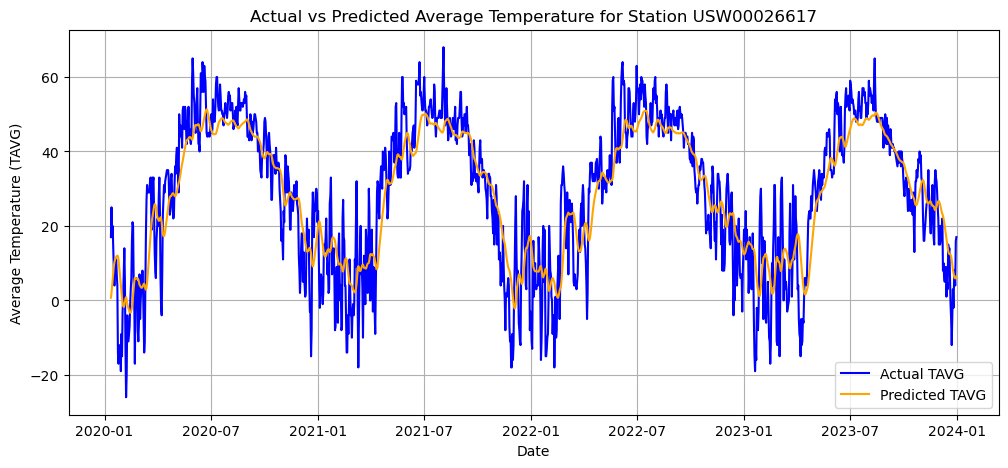

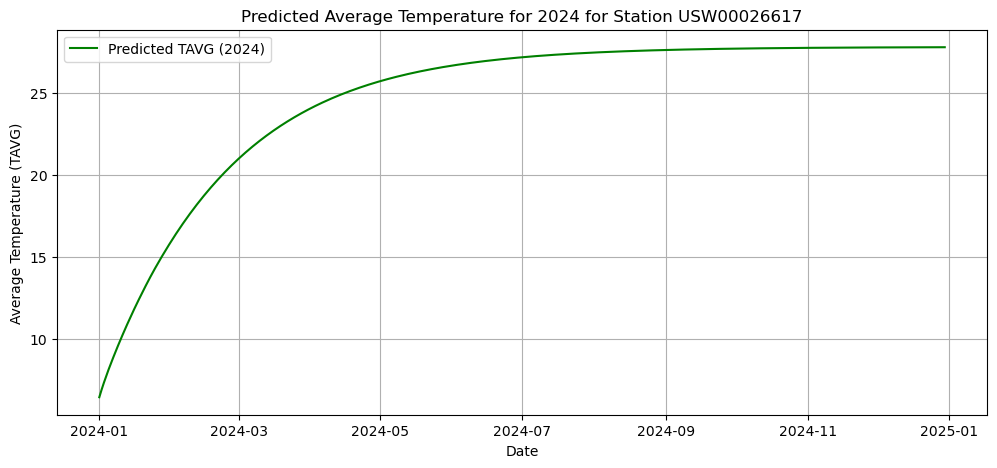

Processing Station USW00014922...
Average TAVG for Station USW00014922: 47.66


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


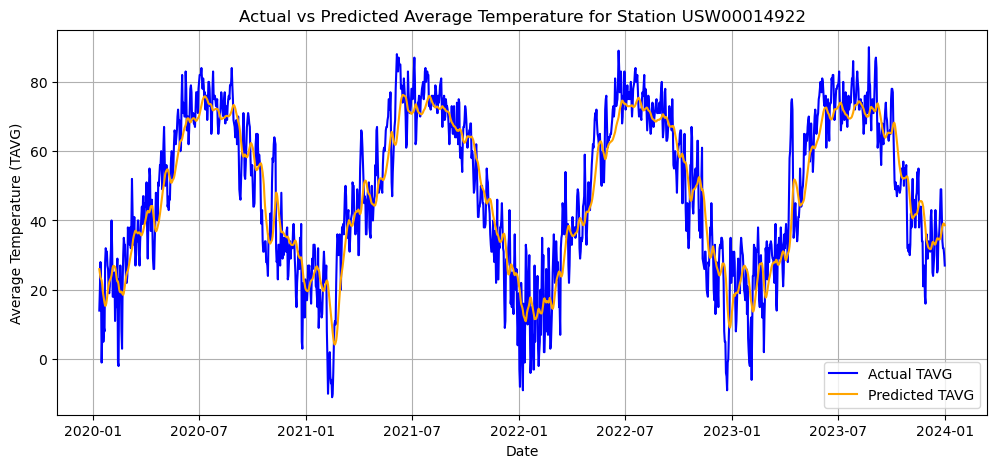

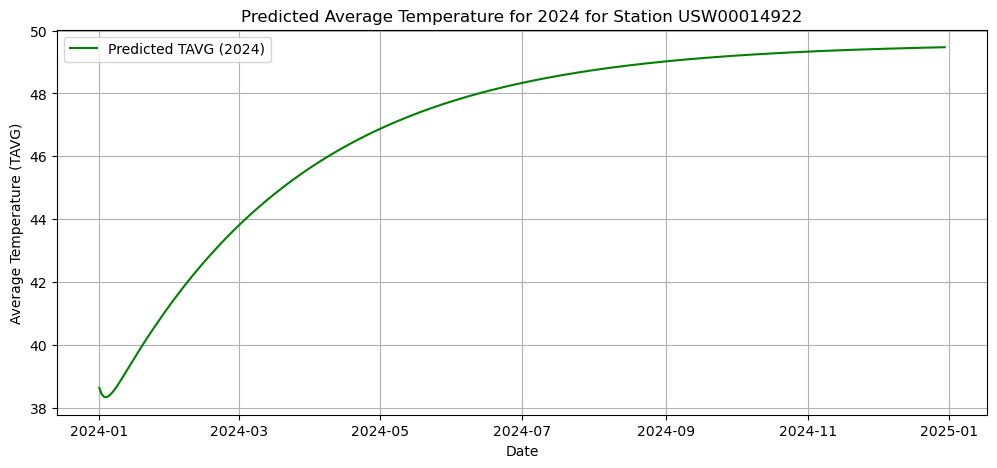

Processing Station USW00003927...
Average TAVG for Station USW00003927: 67.67


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


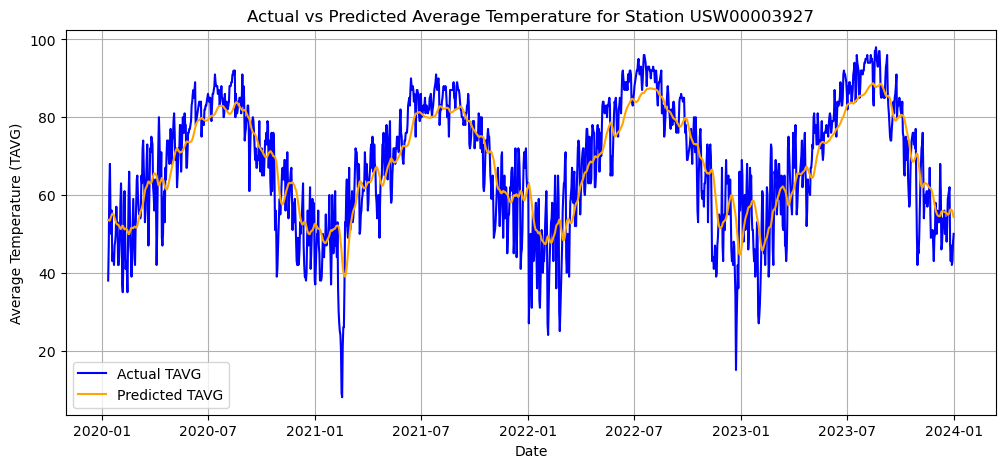

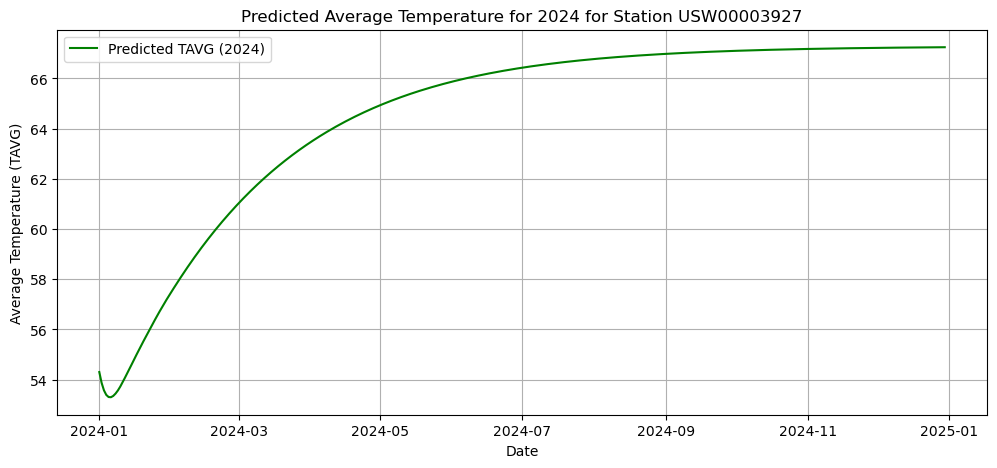

Processing Station USW00012839...
Average TAVG for Station USW00012839: 78.22


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


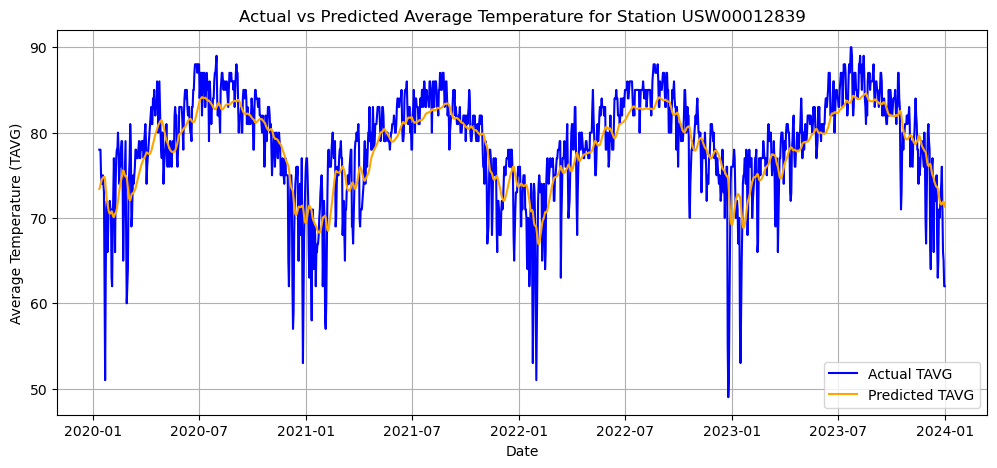

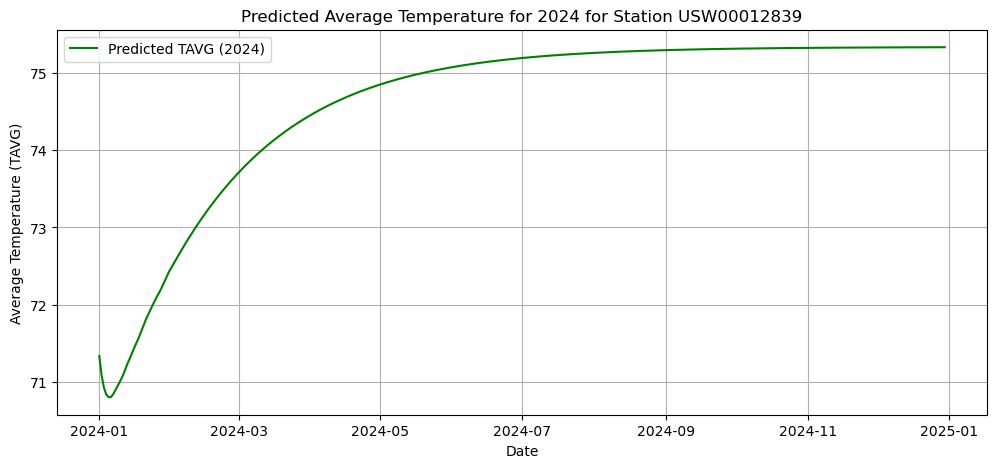

Processing Station USW00023183...
Average TAVG for Station USW00023183: 76.63


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


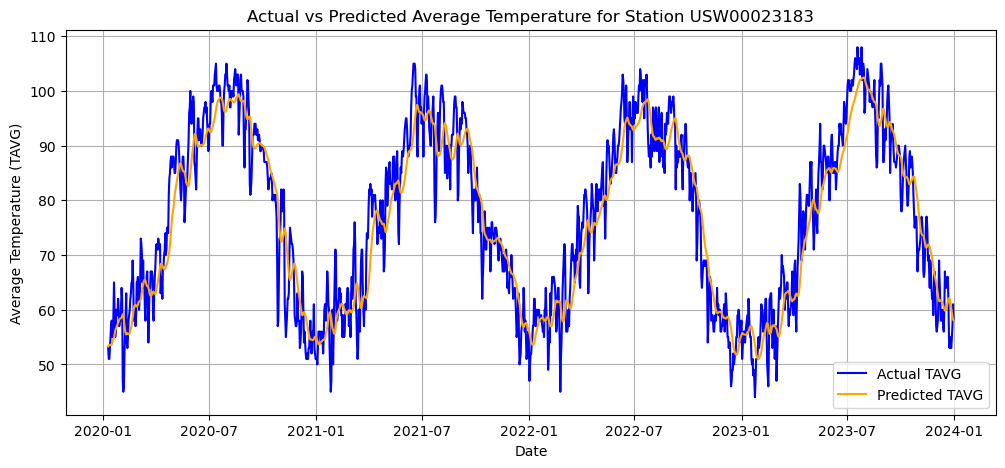

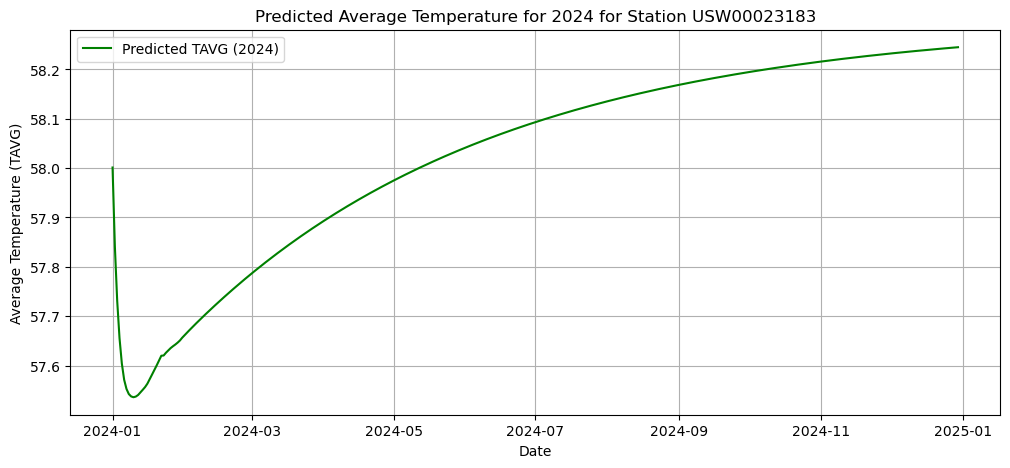

Processing Station USW00003017...
Average TAVG for Station USW00003017: 51.98


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


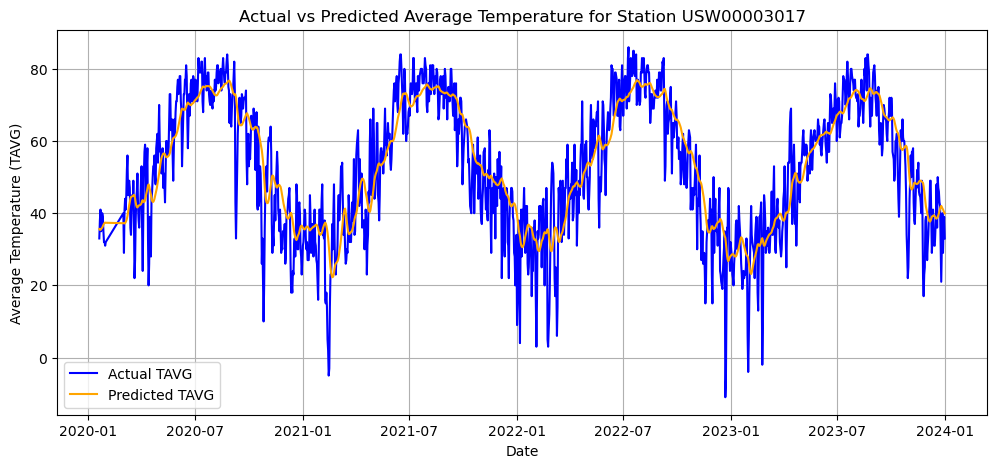

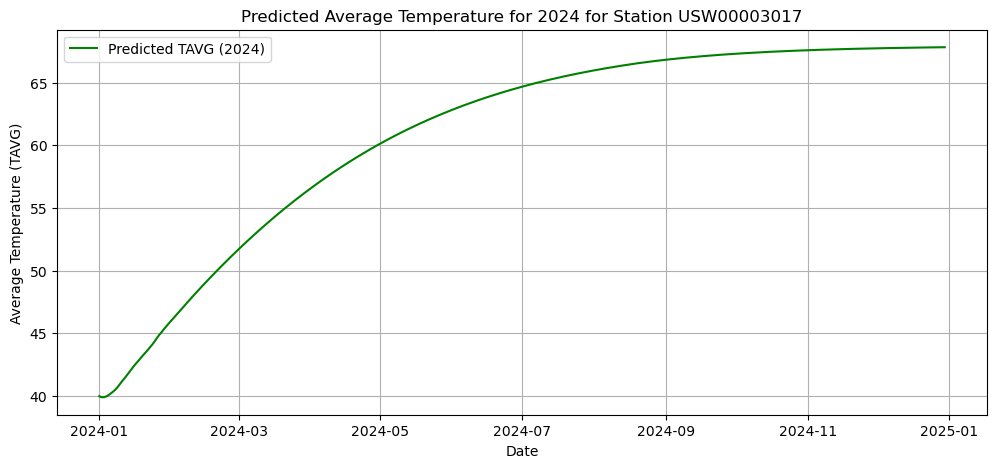

Processing Station USW00025501...
Average TAVG for Station USW00025501: 43.48


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


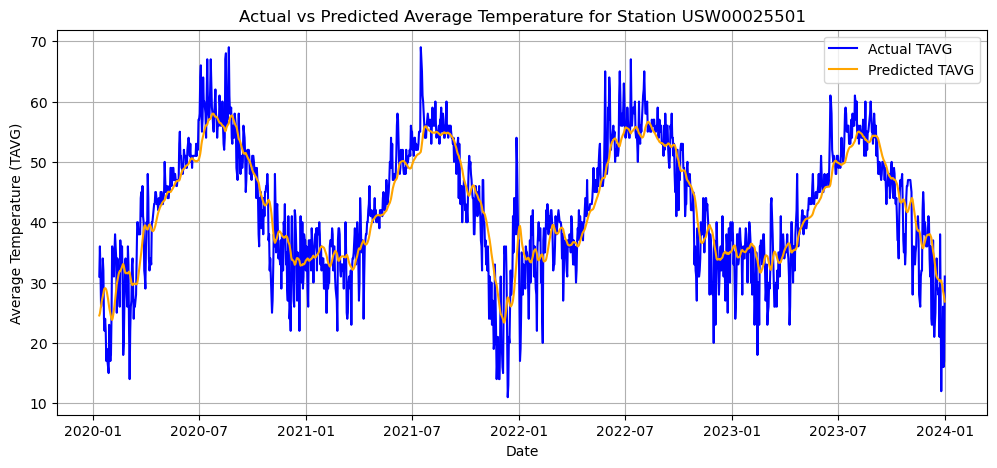

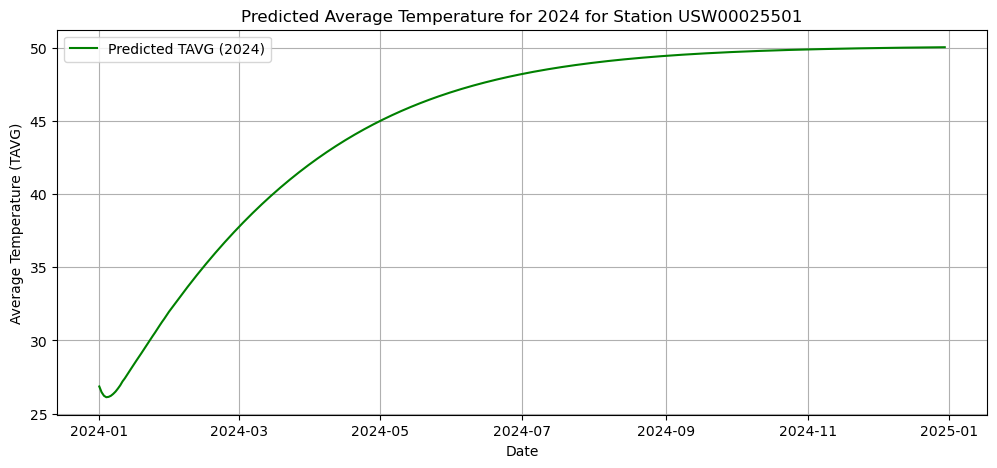

Processing Station USW00024233...
Average TAVG for Station USW00024233: 53.73


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


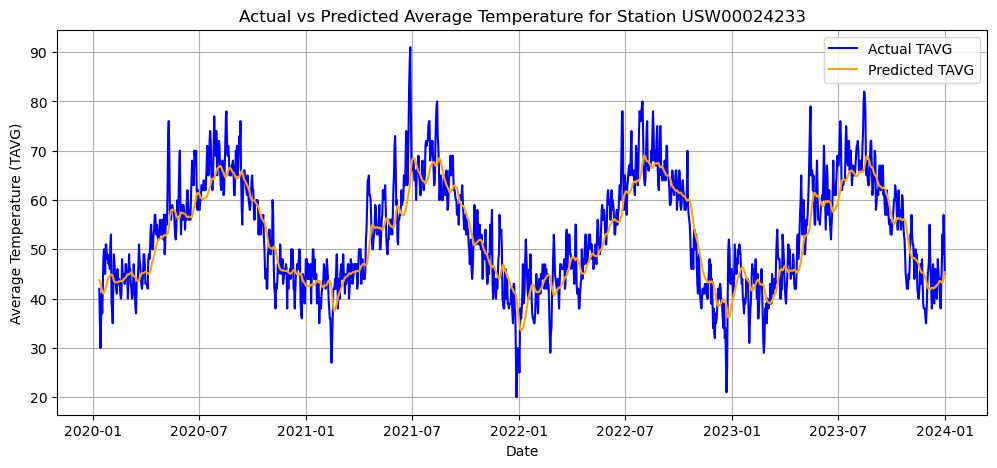

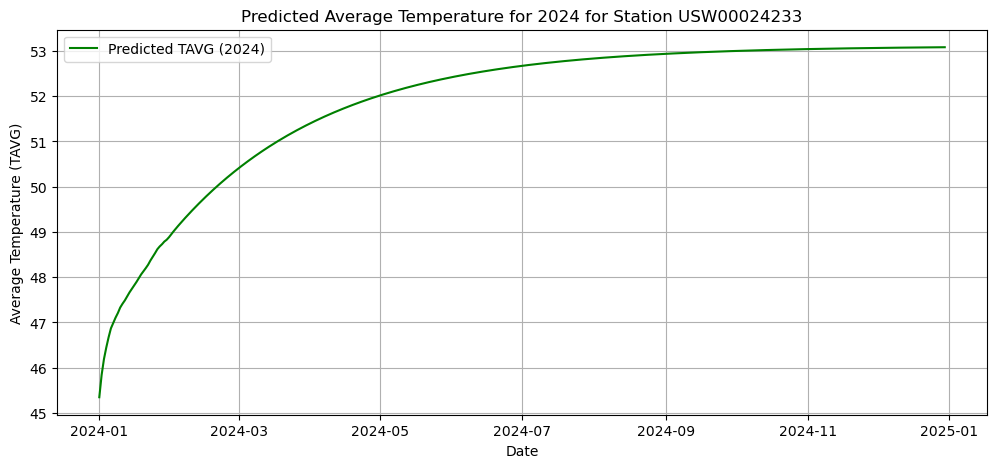

['USW00094846' 'USW00026617' 'USW00014922' 'USW00003927' 'USW00012839'
 'USW00023183' 'USW00003017' 'USW00025501' 'USW00024233']


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import timedelta

# Function to prepare data for LSTM
def prepare_lstm_data(df, sequence_length=30):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['TAVG', 'PRCP', 'SNOW', 'SNWD', 'TSUN']])

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Past `sequence_length` days as features
        y.append(scaled_data[i, 0])  # Target: TAVG (temperature average)

    return np.array(X), np.array(y), scaler

# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to process each station
def process_station(station_id, station_data, sequence_length=30, epochs=3):
    station_data.set_index('DATE', inplace=True)
    
    # Calculate average value of TAVG
    avg_tavg = station_data['TAVG'].mean()
    print(f"Average TAVG for Station {station_id}: {avg_tavg:.2f}")

    # Prepare LSTM data
    X, y, scaler = prepare_lstm_data(station_data, sequence_length)

    # Use only a portion of the data for faster training
    split_index = int(len(X) * 0.6)  # Reduced training size
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Build and train the LSTM model
    lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    lstm_model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test), verbose=0)

    # Make predictions for the test set
    predictions = lstm_model.predict(X_test, verbose=0)
    predicted_tavg = scaler.inverse_transform(
        np.concatenate((predictions, np.zeros((len(predictions), 4))), axis=1)
    )[:, 0]
    actual_tavg = scaler.inverse_transform(
        np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 4))), axis=1)
    )[:, 0]

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 5))
    plt.plot(station_data.index[-len(predicted_tavg):], actual_tavg, label='Actual TAVG', color='blue')
    plt.plot(station_data.index[-len(predicted_tavg):], predicted_tavg, label='Predicted TAVG', color='orange')
    plt.title(f"Actual vs Predicted Average Temperature for Station {station_id}")
    plt.xlabel("Date")
    plt.ylabel("Average Temperature (TAVG)")
    plt.legend()
    plt.grid()
    plt.show()

    # Predict the entire year of 2024
    future_X = X_test[-1:]
    future_predictions = []
    for _ in range(365):  # Predict for the entire year of 2024
        next_pred = lstm_model.predict(future_X, verbose=0)

        # Append the new prediction to the list
        future_predictions.append(next_pred[0, 0])

        # Create the next input by adding the new prediction and removing the oldest timestep
        next_input = np.concatenate([future_X[:, 1:, :], np.array([[[next_pred[0, 0], 0, 0, 0, 0]]])], axis=1)
        future_X = next_input

    # Inverse transform future predictions
    future_dates = pd.date_range(start=pd.Timestamp("2024-01-01"), periods=365, freq='D')
    future_predictions = scaler.inverse_transform(
        np.concatenate((np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), 4))), axis=1)
    )[:, 0]

    # Plot the future predictions
    plt.figure(figsize=(12, 5))
    plt.plot(future_dates, future_predictions, label='Predicted TAVG (2024)', color='green')
    plt.title(f"Predicted Average Temperature for 2024 for Station {station_id}")
    plt.xlabel("Date")
    plt.ylabel("Average Temperature (TAVG)")
    plt.legend()
    plt.grid()
    plt.show()

# Main function
def main():
    # Load the weather dataset
    file_path = "weather_data.csv"
    weather_data = pd.read_csv(file_path)

    # Preprocess the data
    weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
    latest_date = weather_data['DATE'].max()
    start_date = latest_date - pd.DateOffset(years=10)  # Reduced to last 10 years
    relevant_columns = ['STATION', 'DATE', 'TAVG', 'PRCP', 'SNOW', 'SNWD', 'TSUN']
    filtered_data = weather_data[(weather_data['DATE'] >= start_date) & (weather_data['DATE'] <= latest_date)]
    filtered_data = filtered_data[relevant_columns].dropna(subset=['TAVG'])
    filtered_data = filtered_data.fillna({'PRCP': 0.0, 'SNOW': 0.0, 'SNWD': 0.0, 'TSUN': 0.0})

    # Process each station
    stations = filtered_data['STATION'].unique()
    for station_id in stations:
        print(f"Processing Station {station_id}...")
        station_data = filtered_data[filtered_data['STATION'] == station_id]
        process_station(station_id, station_data)
    print(stations)
if __name__ == "__main__":
    main()


Unique station names: ['CHICAGO OHARE INTERNATIONAL AIRPORT, IL US' 'MOUNT SHASTA, CA US'
 'GOLDSTONE ECHO NUMBER 2, CA US' 'NY CITY CENTRAL PARK, NY US'
 'NOME AIRPORT, AK US' 'MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US'
 'LOS ANGELES DOWNTOWN USC, CA US' 'DAL FTW WSCMO AIRPORT, TX US'
 'MIAMI INTERNATIONAL AIRPORT, FL US' 'PHOENIX AIRPORT, AZ US'
 'DENVER INTERNATIONAL AIRPORT, CO US' 'KODIAK AIRPORT, AK US'
 'SEATTLE TACOMA AIRPORT, WA US' 'WHITE SANDS NATIONAL MON., NM US']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


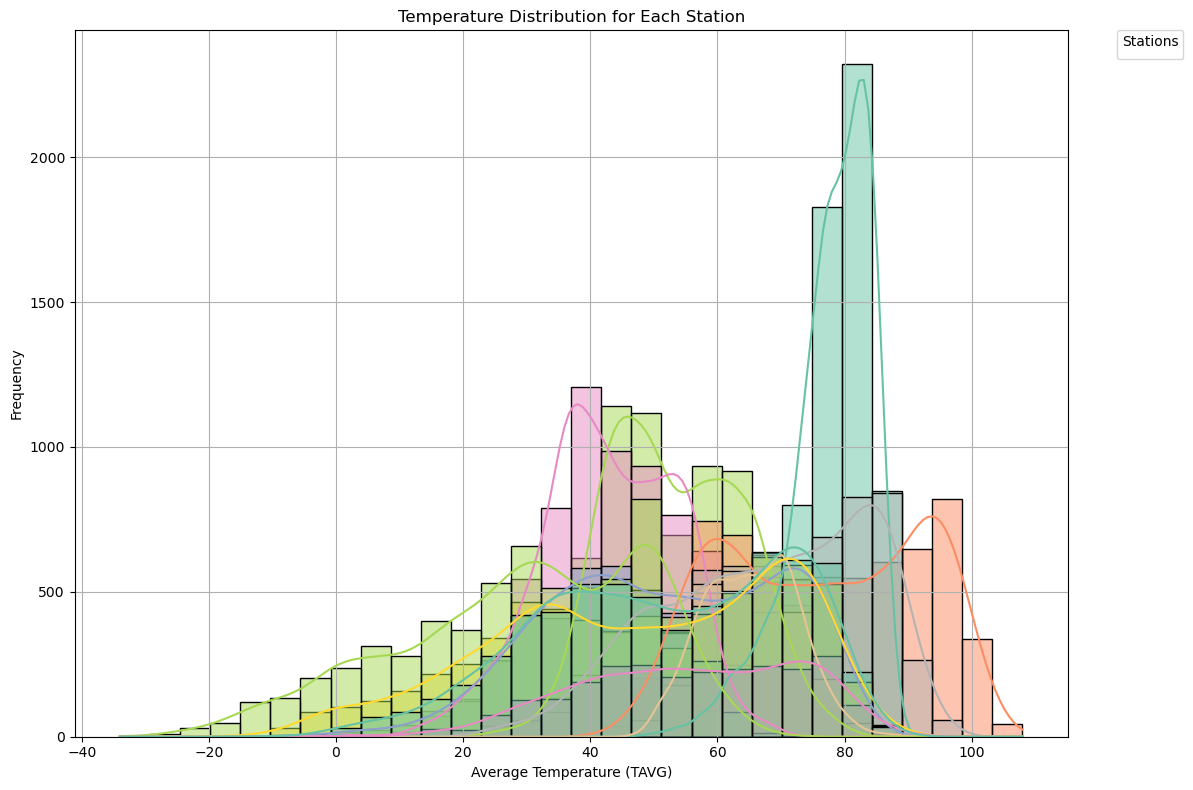

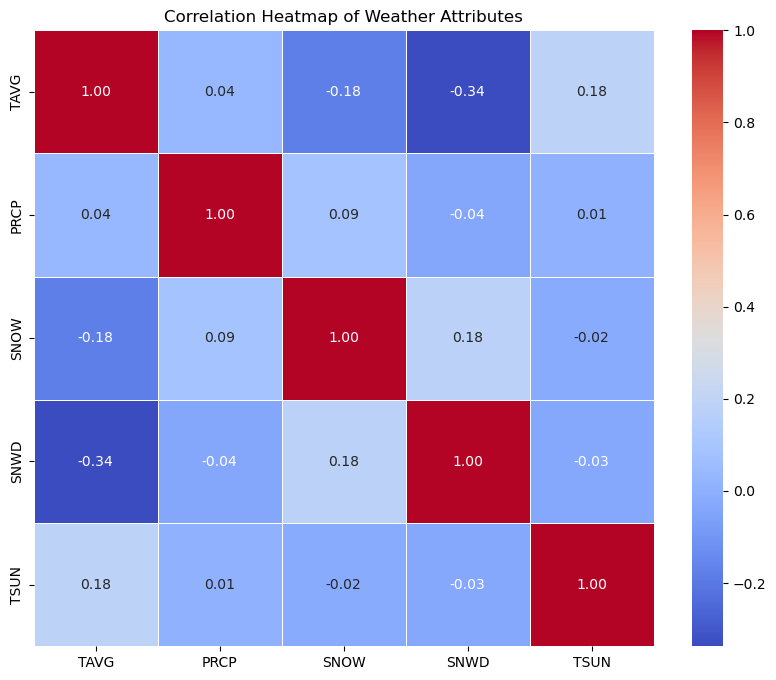

In [20]:
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    import matplotlib.pyplot as plt
    from datetime import timedelta

    def prepare_lstm_data(df, sequence_length=30):
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['TAVG', 'PRCP', 'SNOW', 'SNWD', 'TSUN']])
        X, y = [], []
        for i in range(sequence_length, len(scaled_data)):
            X.append(scaled_data[i-sequence_length:i])
            y.append(scaled_data[i, 0])
        return np.array(X), np.array(y), scaler

    def build_lstm_model(input_shape):
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            LSTM(50, return_sequences=False),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def process_station(station_name, station_data, sequence_length=30, epochs=3):
        station_data.set_index('DATE', inplace=True)
        avg_tavg = station_data['TAVG'].mean()
        print(f"Average TAVG for Station {station_name}: {avg_tavg:.2f}")

        X, y, scaler = prepare_lstm_data(station_data, sequence_length)
        split_index = int(len(X) * 0.6)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
        lstm_model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test), verbose=0)

        predictions = lstm_model.predict(X_test, verbose=0)
        predicted_tavg = scaler.inverse_transform(
            np.concatenate((predictions, np.zeros((len(predictions), 4))), axis=1)
        )[:, 0]

        actual_tavg = scaler.inverse_transform(
            np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 4))), axis=1)
        )[:, 0]

        # Plot Actual vs Predicted for historical data
        plt.figure(figsize=(12, 5))
        plt.plot(station_data.index[-len(predicted_tavg):], actual_tavg, label='Actual TAVG', color='blue')
        plt.plot(station_data.index[-len(predicted_tavg):], predicted_tavg, label='Predicted TAVG', color='orange')
        plt.title(f"Actual vs Predicted Average Temperature for {station_name}")
        plt.xlabel("Date")
        plt.ylabel("Average Temperature (TAVG)")
        plt.legend()
        plt.grid()
        plt.show()

        # Predict for the next 5 years (2025–2029)
        future_X = X_test[-1:]
        future_years = 6  # Including 2024
        yearly_predictions = {}
        for year in range(2024, 2024 + future_years):
            future_predictions = []
            for _ in range(365):  # Assuming 365 days in each year
                next_pred = lstm_model.predict(future_X, verbose=0)
                future_predictions.append(next_pred[0, 0])
                next_input = np.concatenate([future_X[:, 1:, :], np.array([[[next_pred[0, 0], 0, 0, 0, 0]]])], axis=1)
                future_X = next_input
            future_dates = pd.date_range(start=pd.Timestamp(f"{year}-01-01"), periods=365, freq='D')
            yearly_predictions[year] = scaler.inverse_transform(
                np.concatenate((np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), 4))), axis=1)
            )[:, 0]

            # Plot predicted temperatures for each year
            plt.figure(figsize=(12, 5))
            plt.plot(future_dates, yearly_predictions[year], label=f'Predicted TAVG ({year})', color='green')
            plt.title(f"Predicted Average Temperature for {year} for {station_name}")
            plt.xlabel("Date")
            plt.ylabel("Average Temperature (TAVG)")
            plt.legend()
            plt.grid()
            plt.show()

        # Compare yearly averages
        yearly_averages = {year: np.mean(temp) for year, temp in yearly_predictions.items()}
        plt.figure(figsize=(10, 6))
        plt.bar(yearly_averages.keys(), yearly_averages.values(), color='skyblue')
        plt.title(f"Yearly Average Temperatures for {station_name} (2024–2029)")
        plt.xlabel("Year")
        plt.ylabel("Average Temperature (TAVG)")
        plt.grid(axis='y')
        plt.show()

        print(f"Yearly Average Temperatures for {station_name} (2024–2029):")
        for year, avg_temp in yearly_averages.items():
            print(f"  {year}: {avg_temp:.2f}")


    import seaborn as sns

    def plot_temperature_distribution(filtered_data):
        # Debugging: Display unique station names
        print("Unique station names:", filtered_data['NAME'].unique())

        plt.figure(figsize=(12, 8))

        sns.histplot(
            data=filtered_data,
            x='TAVG',
            hue='NAME',  # Use station names from 'NAME' column
            kde=True,
            bins=30,
            palette='Set2',
            legend=True
        )
        plt.title('Temperature Distribution for Each Station')
        plt.xlabel('Average Temperature (TAVG)')
        plt.ylabel('Frequency')
        plt.grid(True)

        # Handle legend placement for large numbers of station names
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(
            handles=handles,
            labels=labels,
            title='Stations',
            bbox_to_anchor=(1.05, 1),  # Place the legend outside the plot
            loc='upper left',
            borderaxespad=0,
            fontsize='small'  # Adjust font size for clarity
        )

        plt.tight_layout()
        plt.show()





    def plot_correlation_heatmap(filtered_data):
        correlation_matrix = filtered_data[['TAVG', 'PRCP', 'SNOW', 'SNWD', 'TSUN']].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap of Weather Attributes')
        plt.show()

    # Call this function in the main block or after preparing the data


    def main():
        file_path = "weather_data.csv"
        weather_data = pd.read_csv(file_path)
        weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
        latest_date = weather_data['DATE'].max()
        start_date = latest_date - pd.DateOffset(years=10)
        relevant_columns = ['STATION', 'DATE', 'TAVG', 'PRCP', 'SNOW', 'SNWD', 'TSUN']
        filtered_data = weather_data[(weather_data['DATE'] >= start_date) & (weather_data['DATE'] <= latest_date)]
        filtered_data = filtered_data[relevant_columns].dropna(subset=['TAVG'])
        filtered_data = filtered_data.fillna({'PRCP': 0.0, 'SNOW': 0.0, 'SNWD': 0.0, 'TSUN': 0.0})
        plot_temperature_distribution(weather_data)
        plot_correlation_heatmap(filtered_data)
#         station_names = {
#             "USC00299686": "New York Central Park, NY",
#             "USC00045983": "Los Angeles USC Campus, CA",
#             "USW00094728": "Chicago O'Hare International Airport, IL",
#             "USW00003927": "Miami International Airport, FL",
#             "USW00012839": "Seattle-Tacoma International Airport, WA",
#             "USW00025501": "Dallas/Fort Worth International Airport, TX",
#             "USW00093134": "Denver International Airport, CO",
#             "USW00024233": "San Francisco International Airport, CA"
#         }
#         stations = filtered_data['STATION'].unique()
#         for station_id in stations:
#             if station_id in station_names:
#                 print(f"Processing {station_names[station_id]}...")
#                 station_data = filtered_data[filtered_data['STATION'] == station_id]
#                 process_station(station_names[station_id], station_data)

    if __name__ == "__main__":
        main()


In [2]:
import seaborn as sns

def plot_temperature_distribution(filtered_data):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=filtered_data, x='TAVG', hue='STATION', kde=True, bins=30, palette='Set2')
    plt.title('Temperature Distribution for Each Station')
    plt.xlabel('Average Temperature (TAVG)')
    plt.ylabel('Frequency')
    plt.legend(title='Stations')
    plt.grid(True)
    plt.show()

# Call this function in the main block or after preparing the data
plot_temperature_distribution(filtered_data)


NameError: name 'filtered_data' is not defined

File successfully read using encoding: utf-8
Columns in the dataset: Index(['STATION', 'NAME', 'DATE', 'ACMC', 'ACMH', 'ACSC', 'ACSH', 'AWND',
       'DAPR', 'FMTM', 'MDPR', 'MDSF', 'PGTM', 'PRCP', 'PSUN', 'SNOW', 'SNWD',
       'TAVG', 'TMAX', 'TMIN', 'TOBS', 'TSUN', 'WDF1', 'WDF2', 'WDF5', 'WDFG',
       'WDFM', 'WESD', 'WSF1', 'WSF2', 'WSF5', 'WSFG', 'WSFM', 'WT01', 'WT02',
       'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11',
       'WT13', 'WT14', 'WT15', 'WT16', 'WT17', 'WT18', 'WT19', 'WT21', 'WT22',
       'WV01', 'WV03', 'WV07', 'WV18', 'WV20'],
      dtype='object')
Unique station names: ['CHICAGO OHARE INTERNATIONAL AIRPORT, IL US'
 'NY CITY CENTRAL PARK, NY US' 'NOME AIRPORT, AK US'
 'MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US'
 'LOS ANGELES DOWNTOWN USC, CA US' 'DAL FTW WSCMO AIRPORT, TX US'
 'MIAMI INTERNATIONAL AIRPORT, FL US' 'PHOENIX AIRPORT, AZ US'
 'DENVER INTERNATIONAL AIRPORT, CO US' 'KODIAK AIRPORT, AK US'
 'SEATTLE TACOMA AIRPORT, 

NameError: name 'handles' is not defined

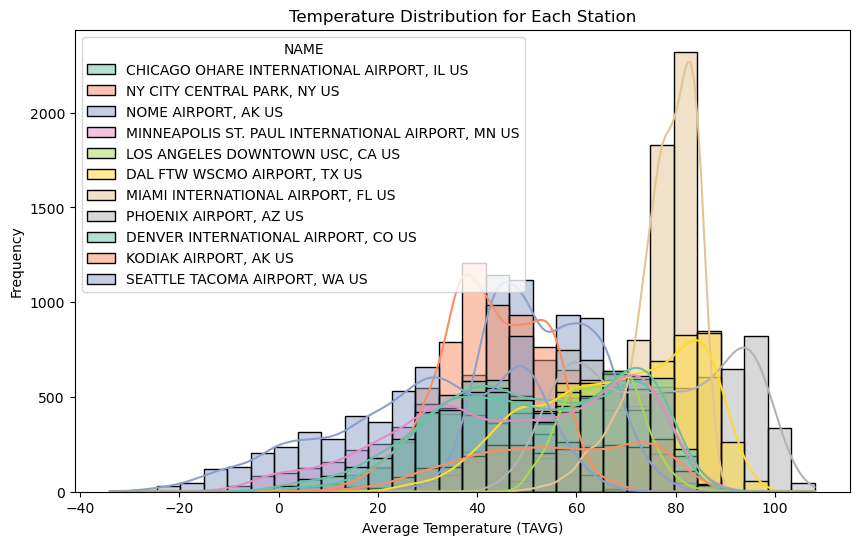

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_temperature_distribution_from_csv(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at path: {file_path}")
        return

    try:
        # Load the dataset with improved encoding handling
        for encoding in ['utf-8', 'latin1', 'cp1252', 'unicode_escape']: # Try multiple encodings
            try:
                weather_data = pd.read_csv(file_path, encoding=encoding, low_memory=False)
                print(f"File successfully read using encoding: {encoding}")
                break # Exit the loop if successful
            except UnicodeDecodeError:
                print(f"Trying next encoding. Failed with: {encoding}")
                continue
        else: # This 'else' is associated with the 'for' loop
            print(f"Error: Could not decode file using common encodings. Please check the file encoding or try opening in a text editor and saving as UTF-8.")
            return

    except pd.errors.ParserError as e:
        print(f"Pandas ParserError: {e}. Check for malformed lines in your CSV.")
        return
    except Exception as e:
        print(f"An unexpected error occurred during file reading: {e}")
        return

    # Check the columns
    print("Columns in the dataset:", weather_data.columns)

    required_columns = ['NAME', 'TAVG']
    if not all(col in weather_data.columns for col in required_columns):
        print(f"Error: Dataset must contain the following columns: {required_columns}")
        return

    # Data Cleaning and Validation
    weather_data = weather_data.dropna(subset=['TAVG', 'NAME']) # Drop rows with missing TAVG OR NAME
    weather_data['NAME'] = weather_data['NAME'].str.strip() # Remove leading/trailing spaces from station names
    weather_data = weather_data[weather_data['NAME'] != ''] # Remove rows with empty station names

    try:
        weather_data['TAVG'] = pd.to_numeric(weather_data['TAVG'], errors='coerce') # Convert TAVG to numeric, setting invalid values to NaN
        weather_data = weather_data.dropna(subset=['TAVG']) # Remove newly introduced NaNs from the conversion
    except KeyError:
        print("Error: 'TAVG' column not found.")
        return

    # Debugging: Check unique station names
    unique_names = weather_data['NAME'].unique()
    print("Unique station names:", unique_names)

    if not unique_names.size:
        print("Error: No valid station names found after data cleaning.")
        return
    
    # Plot histogram
    plt.figure(figsize=(10,6))
    sns.histplot(
        data=weather_data,
        x='TAVG',
        hue='NAME',
        kde=True,
        bins=30,
        palette='Set2',
        legend = True # Only show the legend if there are fewer than 10 stations
    )
    plt.title('Temperature Distribution for Each Station')
    plt.xlabel('Average Temperature (TAVG)')
    plt.ylabel('Frequency')
    plt.legend(
            handles=handles,
            labels=labels,
            title='Stations',
            bbox_to_anchor=(1.05, 1),  # Place the legend outside the plot
            loc='upper left',
            borderaxespad=0,
            fontsize='small'  # Adjust font size for clarity
        )
    plt.grid(True)
    
    if unique_names.size >= 10:
        plt.text(1.05, 0.5, f"Number of stations: {unique_names.size}. Legend omitted for clarity.", transform=plt.gcf().transFigure)

    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to prevent labels from overlapping
    plt.show()


# Example usage (replace with your actual file path)
file_path = 'weather_data.csv'
plot_temperature_distribution_from_csv(file_path)

NameError: name 'extensions' is not defined